# Exploiting all the methods tried so far

In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = metrics.accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold

# optimal mlp for tfidf
def get_mlp():
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 200,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return clf

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,7)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_score = 0
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        clf = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        clf.fit(X_train_v, y_train_v)
        y_pred = clf.predict(X_val)        
        y_prob = clf.predict_proba(X_val)[:,1]
        
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_prob, pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        print('AUC: {a:.3f}'.format(a=roc_auc))       
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation AUC = {a:.3f})'.format(a=best_score))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 10, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return clf

def train_test(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]
    test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)
    return test_metrics
    


# Load data

In [3]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string

df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]
df = df[df['viral']==1]

df.reset_index(drop=True,inplace=True)
df.tail(3)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma,timestamp
5281,657760642306071754,28/10/18,22:19,55,BRASIL,BRA,63,Tocantins,2018_8,0,...,68,12,1,2,Alguem tirou fotos do boletim de urna? Podem ...,1,alguem tirou fotos boletim urna ? podem enviar...,algu tir fot boletim urn ? pod envi mim ? grat,alguem tirar foto boletim urna ? poder enviar ...,2018-10-28 22:19:00
5282,3795679520023557695,28/10/18,22:25,55,BRASIL,BRA,62,Goiás,2018_44,0,...,49,8,1,2,Em frente a polícia federal... Dormitório do Lula,0,frente policia federal . . . dormitorio lula,frent polic feder . . . dormitori lul,frente policiar federal . . . dormitorio lula,2018-10-28 22:25:00
5283,-2345811543631484060,28/10/18,23:03,?,?,?,?,?,2018_4,0,...,50,9,1,2,Se alguém aí quiser sair pra facilitar eu agra...,0,alguem ai quiser sair pra facilitar agradeco,algu ai quis sair pra facil agradec,alguem ai querer sair pra facilitar agradeco,2018-10-28 23:03:00


In [4]:
print('manually labelled messages:',len(df[df['shares']>1]))

manually labelled messages: 5284


## Expansion of dataset

In [5]:
# # Automatic expansion of dataset by cosine similarity

# from sklearn.metrics.pairwise import cosine_similarity

# vectorizer = TfidfVectorizer(max_features = None, ngram_range = (1,1), #(1,3) 
#                              lowercase = False, token_pattern = r'[^\s]+',binary=True)

# non_labelled_texts = df['text']
# labelled_texts = df[df['shares']>1]['text']
# manual_labels = df[df['shares']>1]['misinformation']

# non_labelled_tfidf = vectorizer.fit_transform(non_labelled_texts)  
# labelled_tfidf = vectorizer.transform(labelled_texts)


# print(non_labelled_tfidf.shape)
# print(labelled_tfidf.shape)

# start_time = time.time()
# max_sims = np.array([])
# max_args = np.array([])
# for nl in non_labelled_tfidf:
#     sims = cosine_similarity(nl,labelled_tfidf)[0]
#     max_sim = sims.max()
#     max_arg = sims.argmax()
#     max_sims = np.append(max_sims,max_sim)
#     max_args = np.append(max_args,max_arg)
    
# end_time = time.time()

# print('time:',end_time-start_time)
    
#similarities = cosine_similarity(non_labelled_tfidf,labelled_tfidf)
#     #max similaritie for each document
#     max_sim = distances.max(axis = 1)
#     max_arg = distances.argmax(axis = 1)

In [6]:
#pd.set_option('display.max_colwidth', None)

# #indexes of messages that have to be labelled
# mask = (max_sims < 1) & (max_sims >= 0.9)
# to_be_assigned_idx = max_args[mask].astype(int)
## labels to be assigned
# print(mask.sum())
# df[mask][['viral','shares','misinformation','text']]
# df.iloc[to_be_assigned_idx]

# texts that need to be labelled from non-labelled
# to_be_labelled_texts = non_labelled_texts[mask].reset_index(drop=True)

# to_be_labelled_idx = max_args[mask]
# max_args.shape
# df[to_be_labelled_idx][['text','viral','misinformation']]

#best_matches = np.array(labelled_texts)[to_be_labelled_idx]
#assigned_labels = labels[to_be_labelled_idx].reset_index(drop=True)

In [7]:
# select data

#texts
original_texts = df['text']
texts = df['preprocessed_text_lemma']
#target
y = df['misinformation']

# cut index
cut = math.floor(len(df)*0.8)
cut

4227

data balance in dataset


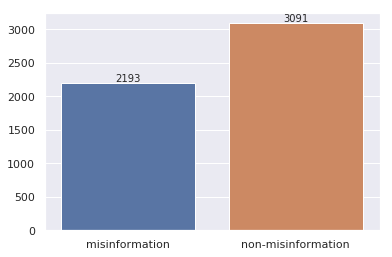

In [8]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
print('data balance in dataset')        
print_class_balance(y)

# Train-test split

train
test


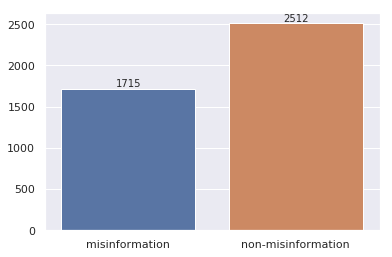

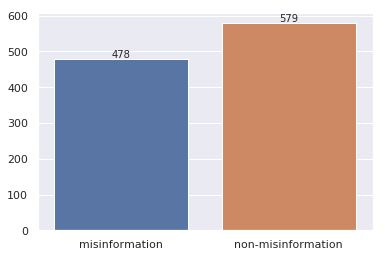

In [9]:
# use only characters
# texts = df['text']
# texts = [' '.join(list(t)) for t in texts]

# train with the 80% older messages; test with the 20% newer
# split by time

X_train_texts = texts[0:cut]
y_train= y[0:cut]
X_test_texts = texts[cut:]
y_test = y[cut:]

X_train_og_texts = original_texts[0:cut]
X_test_og_texts = original_texts[cut:]

corpus = [t.split() for t in corpus if t not in X_test_texts and type(t)==str]

print('train')
print_class_balance(y_train)
plt.figure()
print('test')
print_class_balance(y_test)

In [10]:
len(corpus)

99016

In [11]:
print('samples train')
pos_mask = y_train == 1 
mis = X_train_og_texts[pos_mask]
neg_mask = y_train == 0 
non_mis = X_train_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples train

misinformation
*********
Cabo Daciolo👆
Ouça e se possível, divulgue.

---------------------------------------
non misinformation
*********
Nova mensagem do Michel Temer para o Geraldo Alckmin (parte 2). 🤣🤣🤣🤣



In [12]:
print('samples test')
pos_mask = y_test == 1 
mis = X_test_og_texts[pos_mask]
neg_mask = y_test == 0 
non_mis = X_test_og_texts[neg_mask]
sample = list(mis.sample(1))
print()
print('misinformation')
for m in sample:
    print('*********')
    print(m)
    print()
    
sample = list(non_mis.sample(1))
print('---------------------------------------')
print('non misinformation')
for m in sample:
    print('*********')
    print(m)
    print()

samples test

misinformation
*********
Vamos compartilhar para mostrar quem realmente são os facistas

---------------------------------------
non misinformation
*********
https://youtu.be/nW0q7MYsjPk

Confira como foi o ato Patriótico de hoje na praça do exército.

Grupos de Direita e Conservadores juntos com Militares! 🇧🇷  💪



# Oversampling

# BoW

In [13]:
#vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (2,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)
vectorizer.fit(X_train_texts)   
X_train = vectorizer.transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
X_train.shape

(4227, 110824)

In [14]:
print(vectorizer.get_feature_names()[100:150])

['! banco', '! bandido', '! banqueiro', '! base', '! basto', '! bernardo', '! bicho', '! bolsar', '! bolsonaristas', '! bolsonaro', '! bom', '! bombardear', '! bora', '! boulos', '! brasil', '! brasilia', '! bu', '! c', '! cada', '! cambar', '! caminhar', '! camiseta', '! campanha', '! canal', '! canalha', '! candidatar', '! candidato', '! canil', '! cansar', '! caos', '! capitalismo', '! capitao', '! caro', '! carrasco', '! carro', '! casar', '! cautela', '! cena', '! cenario', '! centena', '! cesar', '! chamar', '! chance', '! chefe', '! chegar', '! chorar', '! cidadaos', '! circular', '! ciro', '! claro']


logistic regression + binary bow
0.46
              precision    recall  f1-score   support

           0       0.67      0.89      0.76       579
           1       0.78      0.47      0.59       478

    accuracy                           0.70      1057
   macro avg       0.72      0.68      0.68      1057
weighted avg       0.72      0.70      0.69      1057

AUC:  0.7527261690550004


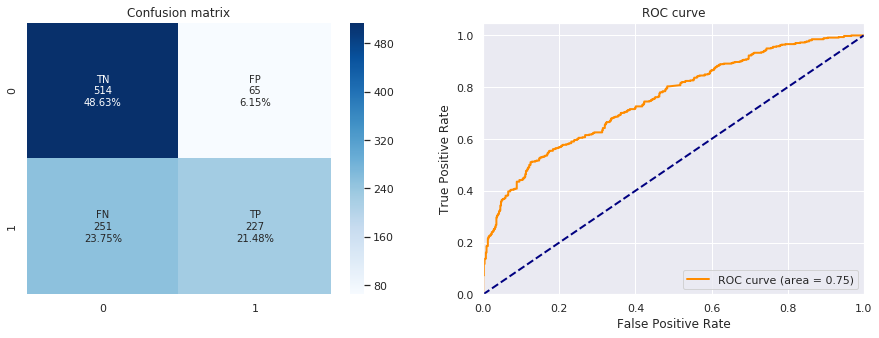

(0.7010406811731315,
 0.7773972602739726,
 0.7648809523809524,
 0.47489539748953974,
 0.7648809523809524,
 0.5896103896103896,
 0.7648809523809524,
 0.7527261690550004)

In [15]:
print('logistic regression + binary bow')
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

#thr = optimal_threshold(y_prob,y_test)
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + bow
Iteration 1, loss = 0.66903919
Validation score: 0.640662
Iteration 2, loss = 0.60676824
Validation score: 0.661939
Iteration 3, loss = 0.55698741
Validation score: 0.671395
Iteration 4, loss = 0.51203258
Validation score: 0.683215
Iteration 5, loss = 0.47170261
Validation score: 0.690307
Iteration 6, loss = 0.43593097
Validation score: 0.704492
Iteration 7, loss = 0.40488468
Validation score: 0.721040
Iteration 8, loss = 0.37679630
Validation score: 0.737589
Iteration 9, loss = 0.35163246
Validation score: 0.742317
Iteration 10, loss = 0.32879375
Validation score: 0.744681
Iteration 11, loss = 0.30810236
Validation score: 0.749409
Iteration 12, loss = 0.28929737
Validation score: 0.749409
Iteration 13, loss = 0.27181616
Validation score: 0.749409
Iteration 14, loss = 0.25599092
Validation score: 0.756501
Iteration 15, loss = 0.24125051
Validation score: 0.749409
Iteration 16, loss = 0.22753792
Validation score: 0.751773
Iteration 17, loss = 0.21492890
Validation score: 0.751

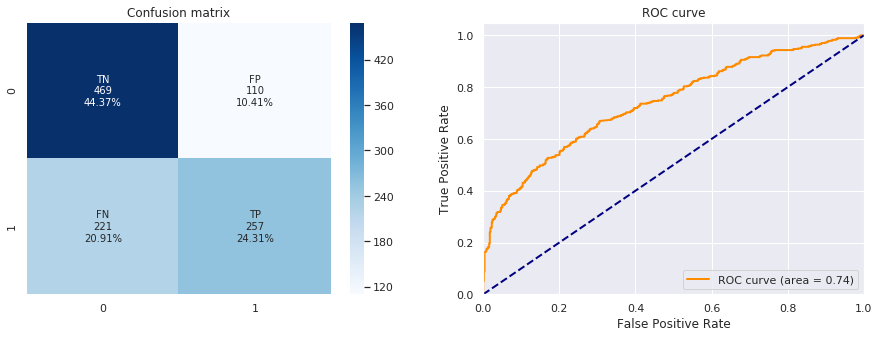

(0.6868495742667928,
 0.7002724795640327,
 0.7391646966115051,
 0.5376569037656904,
 0.7391646966115051,
 0.6082840236686391,
 0.7391646966115051,
 0.7408603782311156)

In [16]:
print('mlp + bow')
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 20,
                   hidden_layer_sizes = (100,), alpha = .0001, 
                   learning_rate_init = .0001, batch_size = 200)

clf.fit(X_train,y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Topic modelling (LDA)

In [17]:
# topics
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
n_topics = 15

def train_lda(corpus, n_topics = 100):
    common_texts = [x.split() for x in corpus]
    common_dictionary = Dictionary(common_texts)
    common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
    lda = LdaModel(common_corpus, num_topics=n_topics)
    return lda, common_dictionary

lda, common_dictionary = train_lda(X_train_texts, n_topics)

In [18]:
# vectorizing
def tup2array(tuples,n_topics):
    topics = np.zeros(n_topics)
    for t, p in tuples:
        topics[t] = p
    return topics

def vectorize_topics(X,lda):
    X = [lda[x] for x in X]
    X = [tup2array(v,lda.num_topics) for v in X]
    return X

def texts2topics(texts,lda):
    X = [x.split() for x in texts]
    X = [common_dictionary.doc2bow(text) for text in X]
    X = vectorize_topics(X,lda)
    return X
    

X_train_topics = texts2topics(X_train_texts,lda)
X_test_topics = texts2topics(X_test_texts,lda)

logistic regression + lda
0.52
              precision    recall  f1-score   support

           0       0.56      0.90      0.69       579
           1       0.51      0.13      0.21       478

    accuracy                           0.55      1057
   macro avg       0.53      0.51      0.45      1057
weighted avg       0.54      0.55      0.47      1057

AUC:  0.5828003844458416


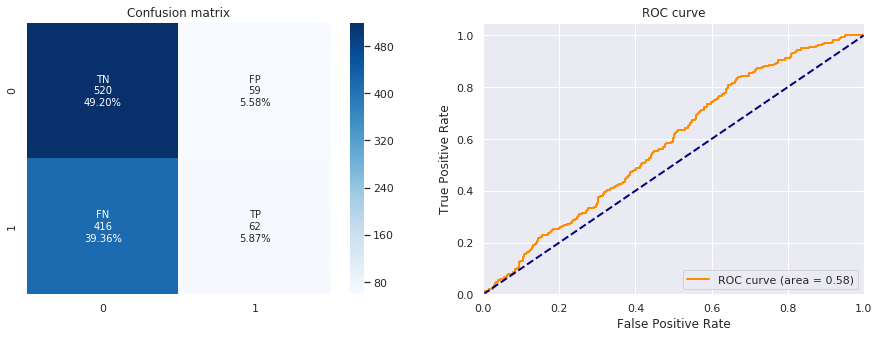

In [19]:
print('logistic regression + lda')
clf = LogisticRegression()
clf.fit(X_train_topics,y_train)
y_prob = clf.predict_proba(X_test_topics)[:,1]
y_prob_train = clf.predict_proba(X_train_topics)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + lda
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.640
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.628
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.648
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.644
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.659
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.616
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.646
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.651
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.668
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.663

--------------------
BEST PARAMETERS (validation AUC = 0.668)
hidden l

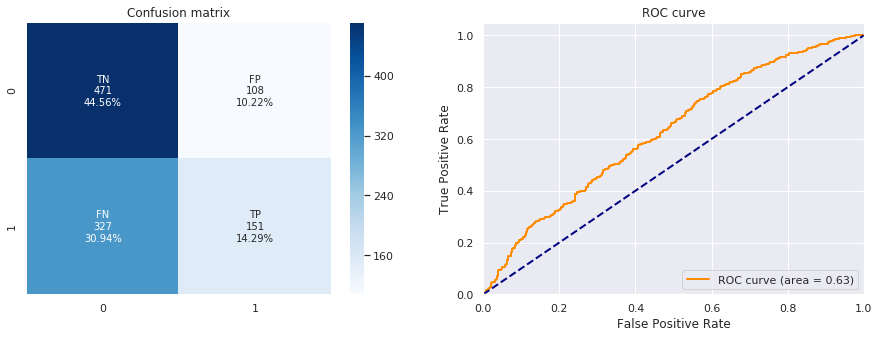

In [20]:
print('mlp + lda')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train_topics,y_train)
y_prob = clf.predict_proba(X_test_topics)[:,1]
y_prob_train = clf.predict_proba(X_train_topics)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Spreading features
* How many times the message was shared
* How many people have seen it
* How many groups
* Features from users that shared the message / credibility
* Spreading velocity

# Combine with other viral messages sent by users
**Ideias**
* get the last texts from the user who sent the message
* get all viral texts sent by all users
* use unique texts or count the repeated?
* weight the words from principal message
* count number of times that each user posted the messages

In [21]:
def combine_texts(list_texts,X_train_texts,constant=5):
    
    combined_texts_train = []
    
    for text in list_texts:
        
        if len(text.split()) >= 50:
            combined_texts_train.append(text)
            continue
            
        users = df[df['preprocessed_text_lemma']==text]['id'].unique()
        viral_texts = []
        for user in users:
            viral_texts_user = df[df['id']==user]['preprocessed_text_lemma'].unique() #use only unique texts
            viral_texts_user = list(viral_texts_user)
            # use only texts in train set
            viral_texts_user = [t for t in viral_texts_user if t in X_train_texts]
            if viral_texts_user:
                viral_texts.append(viral_texts_user)

        # discard repeated texts
        if not viral_texts:
            viral_texts = ''

        viral_texts = set(viral_texts)
        viral_texts.discard(text)

        # weight message        
        weighted = [text]*(constant) # or use constant: 5 *len(users)+

        # join texts
        combined = weighted + list(viral_texts)
        combined = ' '.join(combined)
        combined_texts_train.append(combined)
    return combined_texts_train
    
    

In [22]:
combined_texts_train = combine_texts(X_train_texts,X_train_texts,20)
combined_texts_test = combine_texts(X_test_texts,X_train_texts,20)

In [23]:
# vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), 
#                              lowercase = True, token_pattern = r'[^\s]+')
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+')
vectorizer.fit(combined_texts_train)   
X_train = vectorizer.transform(combined_texts_train)
X_test = vectorizer.transform(combined_texts_test)
X_train.shape

(4227, 303312)

logistic regression + w2v


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.61
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       579
           1       0.63      0.66      0.65       478

    accuracy                           0.67      1057
   macro avg       0.67      0.67      0.67      1057
weighted avg       0.67      0.67      0.67      1057

AUC:  0.7173871412982995


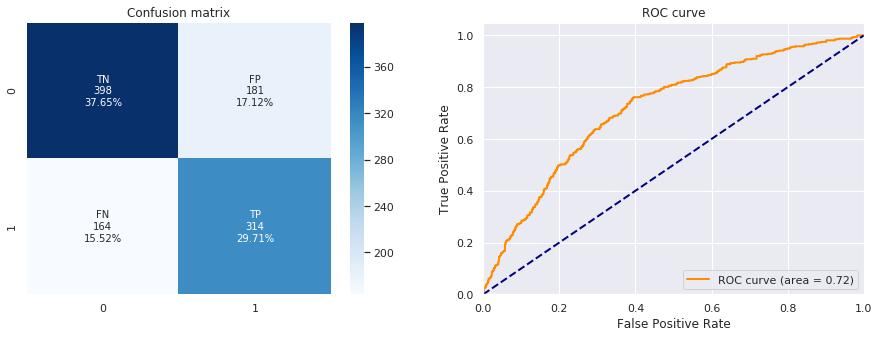

(0.67360454115421,
 0.6343434343434343,
 0.6976336546888694,
 0.6569037656903766,
 0.6976336546888694,
 0.645426515930113,
 0.6976336546888694,
 0.7173871412982995)

In [24]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]

# threshold moving
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)   
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

Iteration 1, loss = 0.57374101
Validation score: 0.739953
Iteration 2, loss = 0.14964212
Validation score: 0.773050
Iteration 3, loss = 0.07219628
Validation score: 0.773050
Iteration 4, loss = 0.04294513
Validation score: 0.770686
Iteration 5, loss = 0.03187166
Validation score: 0.770686
Iteration 6, loss = 0.02499985
Validation score: 0.773050
Validation score did not improve more than tol=0.001000 for 3 consecutive epochs. Stopping.
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       579
           1       0.69      0.59      0.64       478

    accuracy                           0.70      1057
   macro avg       0.69      0.69      0.69      1057
weighted avg       0.69      0.70      0.69      1057

AUC:  0.7625360417976457


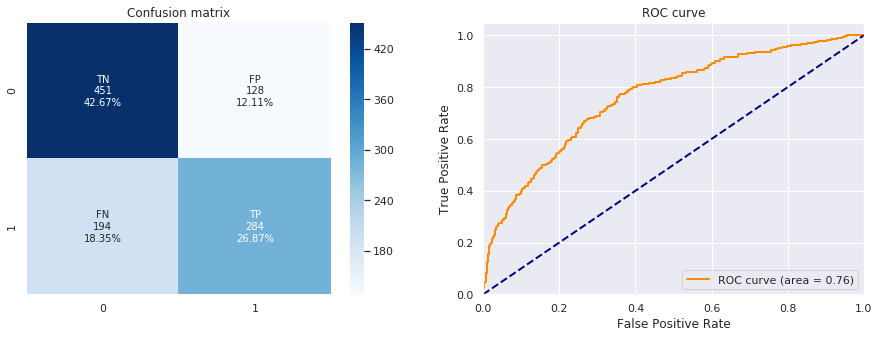

In [25]:
clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-3, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 7,
                   hidden_layer_sizes = (100,), alpha = .00001, 
                   learning_rate_init = .0001, batch_size = 32)
results = train_test(clf,X_train,X_test,y_train,y_test)

# Word embeddings

In [26]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


In [27]:
len(corpus)

99016

In [29]:
class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

w2v = Word2Vec(min_count=1)
w2v.build_vocab(corpus)  # prepare the model vocabulary
w2v.train(corpus, total_examples=w2v.corpus_count, 
            epochs=10, compute_loss=True, 
            callbacks=[epoch_logger])

#w2v = Word2Vec(sentences=corpus, window=5, min_count=1, workers=4, epochs = 10) #callbacks=[epoch_logger]
w2v.save("data/2018/word2vec_train.model")

w2v = Word2Vec.load("data/2018/word2vec_train.model")

W2V: Epoch #1
W2V: Epoch #2
W2V: Epoch #3
W2V: Epoch #4
W2V: Epoch #5
W2V: Epoch #6
W2V: Epoch #7
W2V: Epoch #8
W2V: Epoch #9
W2V: Epoch #10


In [30]:
w2v.most_similar(positive=['deus'])

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('dars', 0.7256976366043091),
 ('oracao', 0.681416928768158),
 ('vosso', 0.6750562191009521),
 ('senhor', 0.6678907871246338),
 ('orar', 0.6430101990699768),
 ('coracao', 0.64110267162323),
 ('ceus', 0.6399680376052856),
 ('fe', 0.6308517456054688),
 ('ti', 0.6237934827804565),
 ('sabedoria', 0.6161242127418518)]

In [31]:
def vectorize_text(model, text, method='mean'):
        """
        Convert all words in a text to their embedding vector
        and calculate a vector for the text, by the mean or the sum of word vectors
        Parameters
        ----------
        text: str
        Text from wich the word vector's will be calculated    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        vec: numpy.ndarray 
        Array of the word embeddings from the given text 
        """
        n = model.vector_size
        X = np.empty(shape=[0, n])
        words = text.split()
        for word in words:
            try:
                vec = model[word]
                X = np.append(X,[vec], axis = 0)
            # if oov:    
            except:
                #print('word not in vocabulary: ', word)
                continue
        if X.size == 0:
            vec = np.zeros(n)
        elif method == 'mean':
            vec = np.mean(X,axis=0)
        elif method == 'sum':
            vec = np.sum(X,axis=0)
        return vec
    
def vectorize_corpus(model, corpus, method='mean'):
        """
        Convert all texts in a corpus to vectors
        Parameters
        ----------
        corpus: list
        List of texts    
        
        method: str
        'mean' or 'sum'
            
        Returns
        -------
        X: numpy.ndarray 
        2D Array of vectors from each text in corpus
        """
        X = [vectorize_text(model, text, method=method) for text in corpus]
        X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
        return X

x = vectorize_corpus(w2v, 'bolsonaro é um prego')
x

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([[-0.82453805,  1.27638006, -0.26101288, ..., -0.08940643,
        -1.30504823,  1.5733397 ],
       [-1.72787321, -2.75208163, -0.92767584, ...,  1.17341995,
         2.50547814,  1.25829995],
       [ 1.55526578,  0.80401951, -0.98164749, ...,  0.69146967,
        -0.23742266,  0.40187043],
       ...,
       [ 0.34047365, -0.00931854, -0.03101608, ...,  0.23115781,
        -0.32061893, -0.26236987],
       [ 0.36371353,  0.12634839, -1.27639186, ...,  0.50062323,
         0.17590277,  1.41873705],
       [-1.72787321, -2.75208163, -0.92767584, ...,  1.17341995,
         2.50547814,  1.25829995]])

In [32]:
X_train = vectorize_corpus(w2v,X_train_texts)
X_test = vectorize_corpus(w2v,X_test_texts)

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


logistic regression + w2v
0.48
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       579
           1       0.65      0.59      0.62       478

    accuracy                           0.67      1057
   macro avg       0.67      0.66      0.67      1057
weighted avg       0.67      0.67      0.67      1057

AUC:  0.7313648550017704


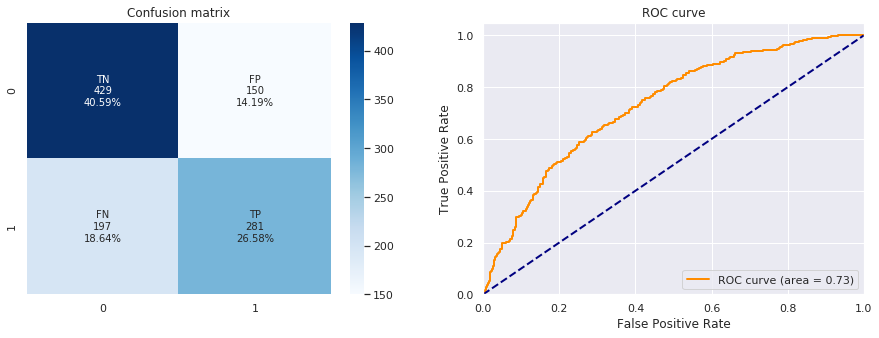

In [33]:
print('logistic regression + w2v')
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.825
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.799
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.846
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.856
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.828
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.824
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.817
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.819
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.832
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.844
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.0012

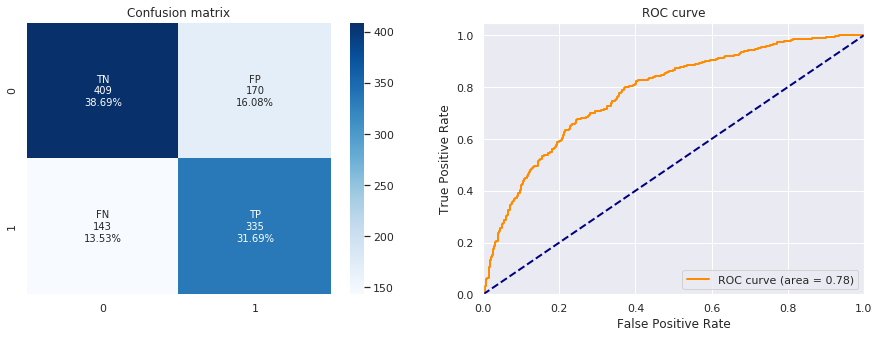

In [34]:
print('mlp + w2v')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=20)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Doc2Vec

In [35]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)
model.save('data/2018/doc2vec.model')

doc2vec = Word2Vec.load("data/2018/doc2vec.model")

In [36]:
doc2vec.infer_vector(['bolsonaro','meu','ovo'])

array([ 0.00550893, -0.02725741,  0.00239243, -0.04717485, -0.00111588,
       -0.03897468, -0.00373799,  0.05220422, -0.00398786,  0.01312905,
       -0.01347694,  0.01423686,  0.00778858, -0.04359187,  0.02417856,
       -0.01376771,  0.02345725, -0.00462097,  0.01220644, -0.03623719,
       -0.0113682 , -0.03838253,  0.00256029, -0.03195629, -0.01893159,
        0.03083579,  0.04568869, -0.02628751,  0.02738073,  0.01181352,
        0.05395945, -0.02360703, -0.0462156 ,  0.02839716, -0.00867428,
       -0.01474901,  0.0247095 , -0.01556824,  0.01094237,  0.01883522,
       -0.03099619, -0.01200587, -0.0354885 , -0.0175048 , -0.0079444 ,
        0.02358471,  0.01567453, -0.0137105 , -0.02075502, -0.00465202,
       -0.02032203, -0.02886818,  0.02069937, -0.0125331 ,  0.03581533,
       -0.01047697,  0.03118426,  0.00534033,  0.00720058, -0.00519949,
        0.01777602,  0.05027952, -0.01531302, -0.0165847 , -0.00662041,
       -0.01282414,  0.01391154,  0.03847056, -0.02565956,  0.01

In [37]:
def vectorize_doc2vec(model,text):
    text = text.split()
    vector = model.infer_vector(text)
    return vector

def vectorize_corpus_doc2vec(model,corpus):
    X = [vectorize_doc2vec(model, text) for text in corpus]
    X = np.concatenate(X, axis=0).reshape(len(X),len(X[0]))
    return X

X_train = vectorize_corpus_doc2vec(doc2vec, X_train_texts)
X_test = vectorize_corpus_doc2vec(doc2vec, X_test_texts)

logistic regression + doc2vec
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       579
           1       0.67      0.60      0.63       478

    accuracy                           0.68      1057
   macro avg       0.68      0.68      0.68      1057
weighted avg       0.68      0.68      0.68      1057

AUC:  0.736145135531612


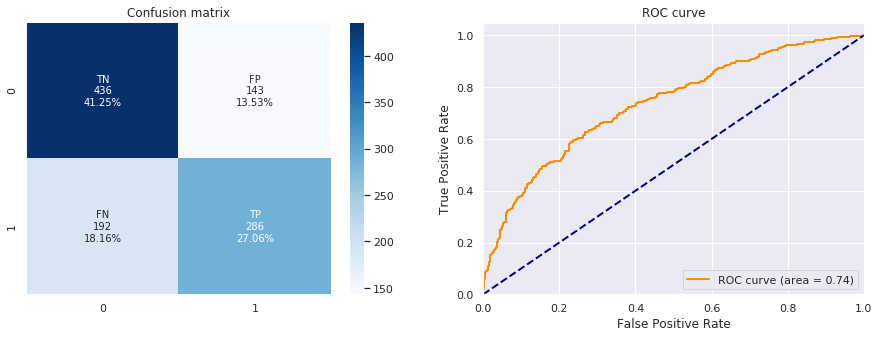

(0.6830652790917692,
 0.6666666666666666,
 0.7224523612261805,
 0.5983263598326359,
 0.7224523612261805,
 0.6306504961411246,
 0.7224523612261805,
 0.736145135531612)

In [38]:
print('logistic regression + doc2vec')
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
y_pred = [1 if p >= thr else 0 for p in y_prob]
get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + doc2vec
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
AUC: 0.779
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
AUC: 0.733
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
AUC: 0.786
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
AUC: 0.790
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
AUC: 0.777
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
AUC: 0.500
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
AUC: 0.777
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
AUC: 0.797
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
AUC: 0.788
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
AUC: 0.807
10 
hidden layers: (75, 300, 25); alpha: 0.00002; learning rate: 0.

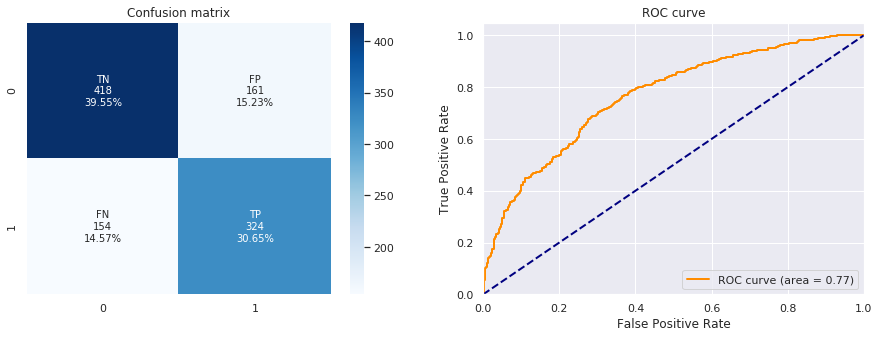

In [39]:
print('mlp + doc2vec')
# clf = MLPClassifier(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-3, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 100,
#                    hidden_layer_sizes = (100,), alpha = .00001, 
#                    learning_rate_init = .0001, batch_size = 32)
# hl,bs,al,lri = random_search_mlp(X_train_topics,y_train,n_iter)
# clf = optimized_mlp(hl,bs,al,lri)

# results = train_test(clf,X_train_topics,X_test_topics,y_train,y_test)

hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter=50)
clf = optimized_mlp(hl,bs,al,lri)
clf.fit(X_train,y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
thr = optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)